In [1]:
#%% Dependencies
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
import WormTool
import os
import scipy.io
import pickle
import statsmodels.api as sm
from find_excursion import ExcurInfo
import pandas as pd
from scipy.stats import pearsonr
#%% Correlation between Dorsal-Ventral bias and orientation change
eig_worms = np.load('data/N2_eigenworms.npy')
name = 'N2'
data = np.load('/Volumes/Lenovo/neuron_ablations/processed/{}.npy'.format(name),allow_pickle=True)
head_curvature = data[:,1]
full_curvature = data[:,2]
orientation_data = data[:,3]

head_data = scipy.io.loadmat('/Volumes/Lenovo/neuron_ablations/hb_dynamics/N2.mat')['N2_hb_dynamics']
fast_mode = [head_data[i,0][:,2] for i in range(len(head_data))]
slow_mode = [head_data[i,0][:,3] for i in range(len(head_data))]

assert len(fast_mode) == len(head_data) and len(slow_mode) == len(head_data)





#%%

In [2]:
from ipywidgets import interact
def plot(i):
    plt.plot(slow_mode[i])
    plt.plot(head_curvature[i])
    plt.show()
interact(plot, i=(0,len(slow_mode)-1))

interactive(children=(IntSlider(value=53, description='i', max=107), Output()), _dom_classes=('widget-interact…

<function __main__.plot(i)>

In [12]:
# 1. Get the excursion-orientation data pairs
with open('excursion_data/excursion_trial_info_dict_MN_ablation.pkl','rb') as f:
    excursion_trial_info_dict = pickle.load(f)

def percentile_mean(s, percentiles=[0, 100]):
    lower_bound = np.percentile(s, percentiles[0])
    upper_bound = np.percentile(s, percentiles[1])
    filtered_values = [x for x in s if lower_bound <= x <= upper_bound]
    return np.mean(filtered_values)


excursion_info = excursion_trial_info_dict[name]
reorientation_ls = []
excursion_vec_ls = []
slow_mode_bias_ls = []
fast_mode_bias_ls = []
curvature_bias_ls = []
curv_amp_bias_ls = []
slow_amp_bias_ls = []
slow_amp_vec_ls = []
slow_dur_bias_ls = []
bin_edge = [-6,-3,0,3,6]
m = 2 # number of eigenworm space cycles
shaffle = True
# Set the random seed
np.random.seed(3)
for i in range(head_curvature.shape[0]):
    if (np.isnan(full_curvature[i])).any():
        continue
    sf = np.sign(np.random.rand()-0.5) if shaffle else 1
    curvature_i = full_curvature[i]
    proj_i = curvature_i.T @ eig_worms[:,:2]
    phase = np.arctan2(proj_i[:,0], proj_i[:,1])
    orientation_i = orientation_data[i] * sf
    phase_jump = np.where(np.abs(np.diff(phase))>np.pi*0.8)[0]
    head_curv_i = head_curvature[i] * sf
    slow_curv_i = slow_mode[i] * sf
    fast_curv_i = fast_mode[i] * sf

    n_jump = len(phase_jump)
    n_record = (n_jump-2)//m
    excursion_ls = excursion_info[i]['excursion_ls']
    excursion_start_ls = [excursion['start'] for excursion in excursion_ls]
    for j in range(n_record):
        start = phase_jump[j*m]
        end = phase_jump[(j+1)*m]
        excursion_vec = np.zeros(len(bin_edge)+1)
        # index of excursions whose start time is in the cycle
        excursion_in_cycle = np.where((np.array(excursion_start_ls)>start) & (np.array(excursion_start_ls)<end))[0]
        if len(excursion_in_cycle) == 0:
            continue
        for index in excursion_in_cycle:
            # excursion_amp = (excursions[index]['sign'].astype(np.float32))*abs(head_curvature_sm[excursions[index]['start']]-head_curvature_sm[excursions[index]['end']])
            # excursion_amp = (np.sign(head_curvature_sm[excursions[index]['pre_peak']]))*abs(head_curvature_sm[excursions[index]['start']]-head_curvature_sm[excursions[index]['end']])
            excursion_amp = (np.sign((head_curv_i[excursion_ls[index]['start']] + head_curv_i[excursion_ls[index]['end']])/2))*abs(head_curv_i[excursion_ls[index]['start']]-head_curv_i[excursion_ls[index]['end']])
            vec_index = np.digitize(excursion_amp, bin_edge)
            excursion_vec[vec_index] += 1
        excursion_vec_ls.append(excursion_vec)
        ori_change = orientation_i[end]-orientation_i[start]
        reorientation_ls.append(ori_change)
        slow_mode_bias_ls.append(np.sum(slow_curv_i[start:end])*0.02)
        fast_mode_bias_ls.append(np.sum(fast_curv_i[start:end])*0.02)
        curvature_bias_ls.append(np.sum(head_curv_i[start:end])*0.02)
        slow_amp_bias_ls.append(np.percentile(slow_curv_i[start:end],95) + np.percentile(slow_curv_i[start:end],5))
        slow_amp_vec_ls.append(percentile_mean(slow_curv_i[start:end],[95,100]),-percentile_mean(slow_curv_i[start:end],[0,5]))
        curv_amp_bias_ls.append(np.percentile(head_curv_i[start:end],95) + np.percentile(head_curv_i[start:end],5))
        slow_dur_bias_ls.append(np.sum(np.sign(head_curv_i[start:end]))*0.02)

excursion_vec_arr = np.array(excursion_vec_ls) # Nx(len(bin_edge)+1)
reorientation_arr = np.array(reorientation_ls) # N
slow_mode_bias_arr = np.array(slow_mode_bias_ls)
fast_mode_bias_arr = np.array(fast_mode_bias_ls)
curvature_bias_arr = np.array(curvature_bias_ls)
curv_amp_bias_arr = np.array(curv_amp_bias_ls)
slow_amp_bias_arr = np.array(slow_amp_bias_ls)
slow_amp_vec_arr = np.array(slow_amp_vec_ls)
slow_dur_bias_arr = np.array(slow_dur_bias_ls)

    


TypeError: list.append() takes exactly one argument (2 given)

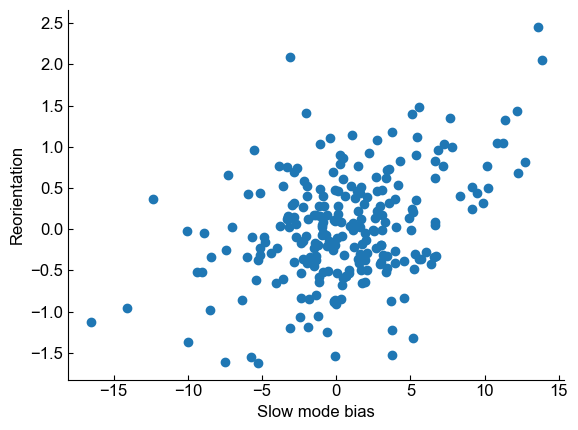

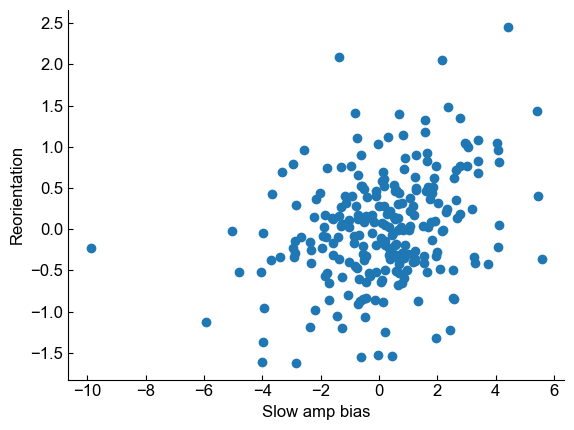

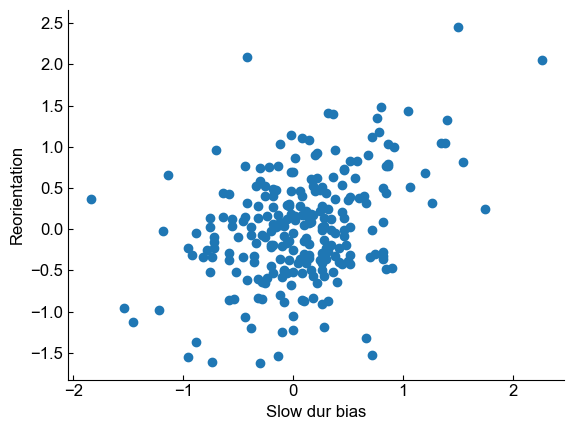

Pearson correlation between slow mode bias and curvature bias: 0.980, p-value: 9.204e-171


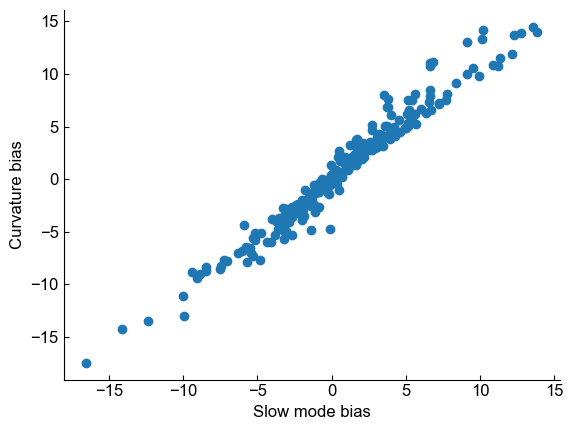

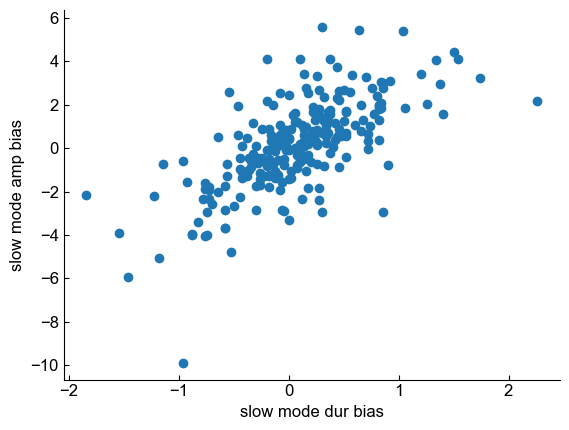

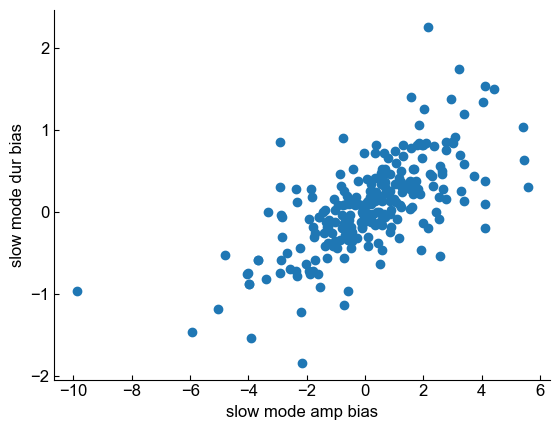

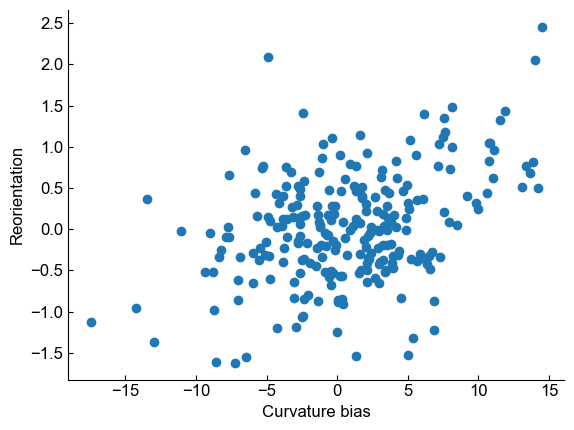

In [46]:
plt.scatter(slow_mode_bias_ls, reorientation_ls)
plt.xlabel('Slow mode bias')
plt.ylabel('Reorientation')
plt.show()

plt.scatter(slow_amp_bias_ls, reorientation_ls)
plt.xlabel('Slow amp bias')
plt.ylabel('Reorientation')
plt.show()

plt.scatter(slow_dur_bias_ls, reorientation_ls)
plt.xlabel('Slow dur bias')
plt.ylabel('Reorientation')
plt.show()

# Calculate Pearson correlation between slow mode bias and curvature bias
pearson_corr, p_value = pearsonr(slow_mode_bias_ls, curvature_bias_ls)
print(f"Pearson correlation between slow mode bias and curvature bias: {pearson_corr:.3f}, p-value: {p_value:.3e}")
plt.scatter(slow_mode_bias_ls, curvature_bias_ls)
plt.xlabel('Slow mode bias')
plt.ylabel('Curvature bias')
plt.show()

plt.scatter(slow_dur_bias_ls, slow_amp_bias_ls)
plt.xlabel('slow mode dur bias')
plt.ylabel('slow mode amp bias')
plt.show()

plt.scatter(slow_amp_bias_ls, slow_dur_bias_ls)
plt.xlabel('slow mode amp bias')
plt.ylabel('slow mode dur bias')
plt.show()
plt.scatter(curvature_bias_ls, reorientation_ls)
plt.xlabel('Curvature bias')
plt.ylabel('Reorientation')
plt.show()



## Linear regression r^2

In [13]:
N_bootstrap = 10000
L = len(excursion_vec_arr)
slow_amp_reori_r2 = []
head_cast_reori_r2 = []
combine_reori_r2 = []
curv_bias_reori_r2 = []
slow_amp_curv_bias_r2 = []
head_cast_curv_bias_r2 = []
combine_curv_bias_r2 = []

def get_r2(x,y,return_coef=False):
    # Perform linear regression using numpy's least squares method
    coef = np.linalg.lstsq(x, y, rcond=None)[0]
    # Predict y values using the regression coefficients

    y_pred = x @ coef
    # Calculate the total sum of squares
    ss_total = np.sum((y - np.mean(y))**2)
    # Calculate the residual sum of squares
    ss_residual = np.sum((y - y_pred)**2)
    # Calculate R^2
    r2 = 1 - (ss_residual / ss_total)
    if return_coef:
        return r2,coef
    else:
        return r2

for i in range(N_bootstrap):
    resample_ind = np.random.choice(L,L,replace=True)
    excursion_vec_resample = excursion_vec_arr[resample_ind]
    reorientation_resample = reorientation_arr[resample_ind]
    slow_bias_resample = slow_mode_bias_arr[resample_ind]
    slow_amp_bias_resample = slow_amp_bias_arr[resample_ind]
    slow_dur_bias_resample = slow_dur_bias_arr[resample_ind]
    curvature_bias_resample = curvature_bias_arr[resample_ind]

    slow_amp_reori_r2.append(get_r2(slow_amp_bias_resample[:,np.newaxis], reorientation_resample))
    head_cast_reori_r2.append(get_r2(excursion_vec_resample, reorientation_resample))
    combine_reori_r2.append(get_r2(np.concatenate([slow_amp_bias_resample[:,np.newaxis], excursion_vec_resample], axis=1), reorientation_resample))
    curv_bias_reori_r2.append(get_r2(curvature_bias_resample[:,np.newaxis], reorientation_resample))
    
    target = curvature_bias_resample
    # target = slow_dur_bias_resample
    slow_amp_curv_bias_r2.append(get_r2(slow_amp_bias_resample[:,np.newaxis], target))
    head_cast_curv_bias_r2.append(get_r2(excursion_vec_resample, target))
    combine_curv_bias_r2.append(get_r2(np.concatenate([slow_amp_bias_resample[:,np.newaxis], excursion_vec_resample], axis=1), target))





    

fontTools.subset - _prune_pre_subset - INFO - maxp pruned
fontTools.subset - _prune_pre_subset - INFO - LTSH dropped
fontTools.subset - _prune_pre_subset - INFO - cmap pruned
fontTools.subset - _prune_pre_subset - INFO - kern dropped
fontTools.subset - _prune_pre_subset - INFO - post pruned
fontTools.subset - _prune_pre_subset - INFO - PCLT dropped
fontTools.subset - _prune_pre_subset - INFO - GPOS pruned
fontTools.subset - _prune_pre_subset - INFO - GSUB pruned
fontTools.subset - _prune_pre_subset - INFO - JSTF dropped
fontTools.subset - _prune_pre_subset - INFO - DSIG dropped
fontTools.subset - _prune_pre_subset - INFO - name pruned
fontTools.subset - _prune_pre_subset - INFO - glyf pruned
fontTools.subset - _closure_glyphs - INFO - Added gid0 to subset
fontTools.subset - _closure_glyphs - INFO - Added first four glyphs to subset
fontTools.subset - _closure_glyphs - INFO - Closing glyph list over 'GSUB': 26 glyphs before
fontTools.subset - _log_glyphs - INFO - Glyph names: ['.notdef'

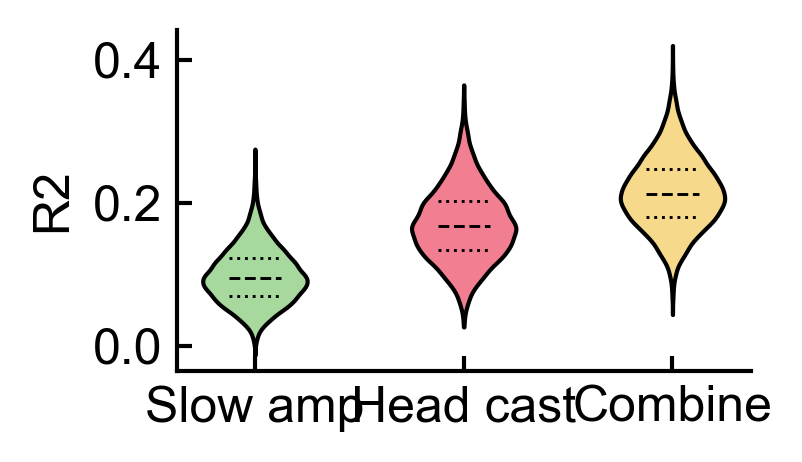

fontTools.subset - _prune_pre_subset - INFO - maxp pruned
fontTools.subset - _prune_pre_subset - INFO - LTSH dropped
fontTools.subset - _prune_pre_subset - INFO - cmap pruned
fontTools.subset - _prune_pre_subset - INFO - kern dropped
fontTools.subset - _prune_pre_subset - INFO - post pruned
fontTools.subset - _prune_pre_subset - INFO - PCLT dropped
fontTools.subset - _prune_pre_subset - INFO - GPOS pruned
fontTools.subset - _prune_pre_subset - INFO - GSUB pruned
fontTools.subset - _prune_pre_subset - INFO - JSTF dropped
fontTools.subset - _prune_pre_subset - INFO - DSIG dropped
fontTools.subset - _prune_pre_subset - INFO - name pruned
fontTools.subset - _prune_pre_subset - INFO - glyf pruned
fontTools.subset - _closure_glyphs - INFO - Added gid0 to subset
fontTools.subset - _closure_glyphs - INFO - Added first four glyphs to subset
fontTools.subset - _closure_glyphs - INFO - Closing glyph list over 'GSUB': 28 glyphs before
fontTools.subset - _log_glyphs - INFO - Glyph names: ['.notdef'

T-statistic: -112.55528095649363, P-value: 0.0


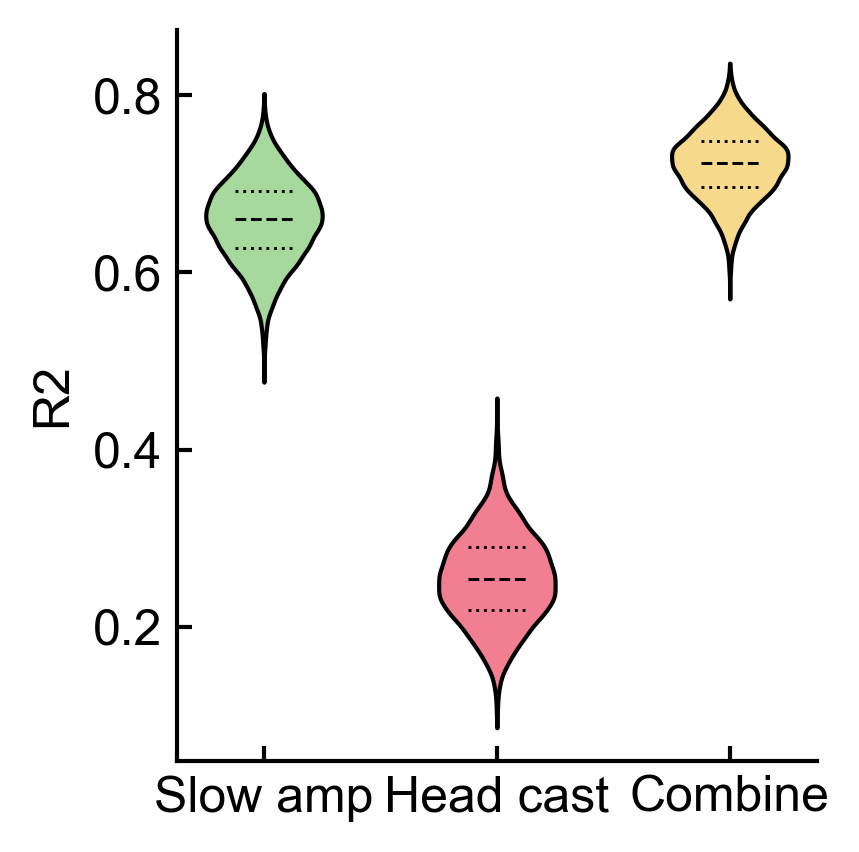

In [22]:
WormTool.statistic_plot.plot_violin([slow_amp_reori_r2,head_cast_reori_r2,combine_reori_r2 ],
                                          label_ls=['Slow amp','Head cast','Combine'],
                                          y_label='R2',size=(2.8,1.7),
                                     save_path='Fig2/Fig2_ori_r2.pdf'    )

from scipy.stats import ttest_ind

# Perform t-test between slow_amp_reori_r2 and head_cast_reori_r2
t_stat, p_value = ttest_ind(slow_amp_reori_r2, head_cast_reori_r2)

# Print the t-statistic and p-value
print(f"T-statistic: {t_stat}, P-value: {p_value}")

WormTool.statistic_plot.plot_violin([slow_amp_curv_bias_r2,head_cast_curv_bias_r2,combine_curv_bias_r2 ],
                                          label_ls=['Slow amp','Head cast','Combine'],
                                          y_label='R2',size=(3,3),
                                        save_path='Fig2/Fig2_curv_bias_2.pdf'
                                         )

In [16]:
N_bootstrap = 10000
L = len(excursion_vec_arr)

combine_reori_coef = []
slow_mode_vec_coef = []

def get_r2(x,y,return_coef=False):
    # Perform linear regression using numpy's least squares method
    coef = np.linalg.lstsq(x, y, rcond=None)[0]
    # Predict y values using the regression coefficients

    y_pred = x @ coef
    # Calculate the total sum of squares
    ss_total = np.sum((y - np.mean(y))**2)
    # Calculate the residual sum of squares
    ss_residual = np.sum((y - y_pred)**2)
    # Calculate R^2
    r2 = 1 - (ss_residual / ss_total)
    if return_coef:
        return r2,coef
    else:
        return r2

for i in range(N_bootstrap):
    resample_ind = np.random.choice(L,L,replace=True)
    excursion_vec_resample = excursion_vec_arr[resample_ind]
    reorientation_resample = reorientation_arr[resample_ind]
    slow_bias_resample = slow_mode_bias_arr[resample_ind]
    slow_amp_bias_resample = slow_amp_bias_arr[resample_ind]
    slow_dur_bias_resample = slow_dur_bias_arr[resample_ind]
    curvature_bias_resample = curvature_bias_arr[resample_ind]
    slow_amp_vec_resample = slow_amp_vec_arr[resample_ind]

    combine_reori_coef.append(get_r2(np.concatenate([slow_amp_vec_resample, excursion_vec_resample], axis=1), reorientation_resample,return_coef=True)[1])
    slow_mode_vec_coef.append(get_r2(slow_amp_vec_resample, reorientation_resample,return_coef=True)[1])
combine_reori_coef = np.array(combine_reori_coef)
slow_mode_vec_coef = np.array(slow_mode_vec_coef)









fontTools.subset - _prune_pre_subset - INFO - maxp pruned
fontTools.subset - _prune_pre_subset - INFO - LTSH dropped
fontTools.subset - _prune_pre_subset - INFO - cmap pruned
fontTools.subset - _prune_pre_subset - INFO - kern dropped
fontTools.subset - _prune_pre_subset - INFO - post pruned
fontTools.subset - _prune_pre_subset - INFO - PCLT dropped
fontTools.subset - _prune_pre_subset - INFO - GPOS pruned
fontTools.subset - _prune_pre_subset - INFO - GSUB pruned
fontTools.subset - _prune_pre_subset - INFO - JSTF dropped
fontTools.subset - _prune_pre_subset - INFO - DSIG dropped
fontTools.subset - _prune_pre_subset - INFO - name pruned
fontTools.subset - _prune_pre_subset - INFO - glyf pruned
fontTools.subset - _closure_glyphs - INFO - Added gid0 to subset
fontTools.subset - _closure_glyphs - INFO - Added first four glyphs to subset
fontTools.subset - _closure_glyphs - INFO - Closing glyph list over 'GSUB': 26 glyphs before
fontTools.subset - _log_glyphs - INFO - Glyph names: ['.notdef'

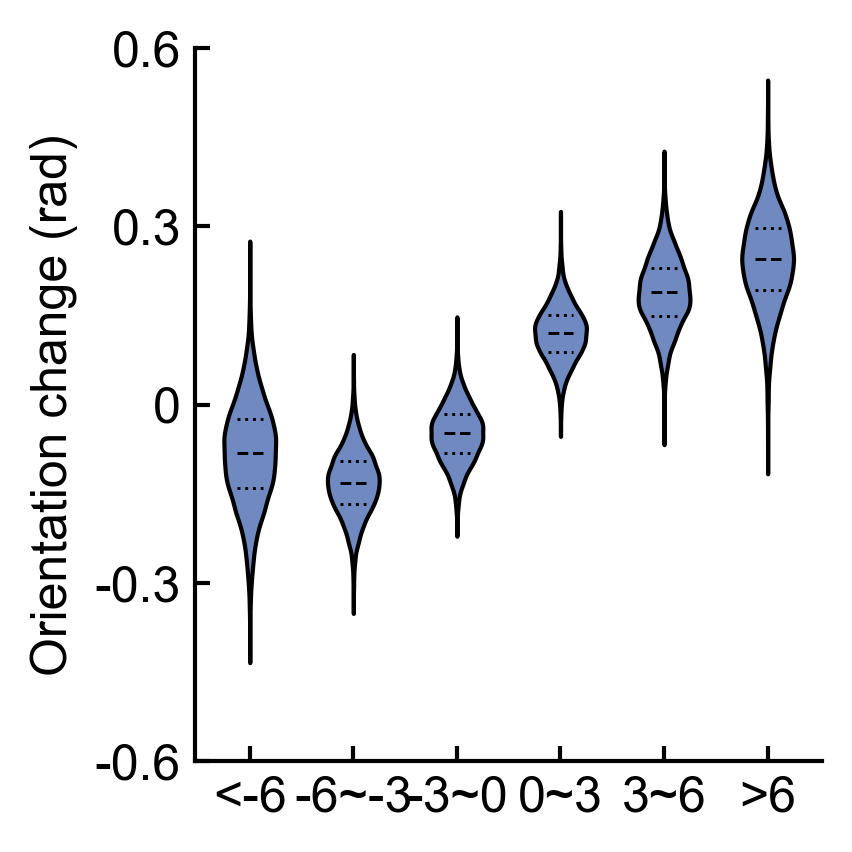

fontTools.subset - _prune_pre_subset - INFO - maxp pruned
fontTools.subset - _prune_pre_subset - INFO - LTSH dropped
fontTools.subset - _prune_pre_subset - INFO - cmap pruned
fontTools.subset - _prune_pre_subset - INFO - kern dropped
fontTools.subset - _prune_pre_subset - INFO - post pruned
fontTools.subset - _prune_pre_subset - INFO - PCLT dropped
fontTools.subset - _prune_pre_subset - INFO - GPOS pruned
fontTools.subset - _prune_pre_subset - INFO - GSUB pruned
fontTools.subset - _prune_pre_subset - INFO - JSTF dropped
fontTools.subset - _prune_pre_subset - INFO - DSIG dropped
fontTools.subset - _prune_pre_subset - INFO - name pruned
fontTools.subset - _prune_pre_subset - INFO - glyf pruned
fontTools.subset - _closure_glyphs - INFO - Added gid0 to subset
fontTools.subset - _closure_glyphs - INFO - Added first four glyphs to subset
fontTools.subset - _closure_glyphs - INFO - Closing glyph list over 'GSUB': 27 glyphs before
fontTools.subset - _log_glyphs - INFO - Glyph names: ['.notdef'

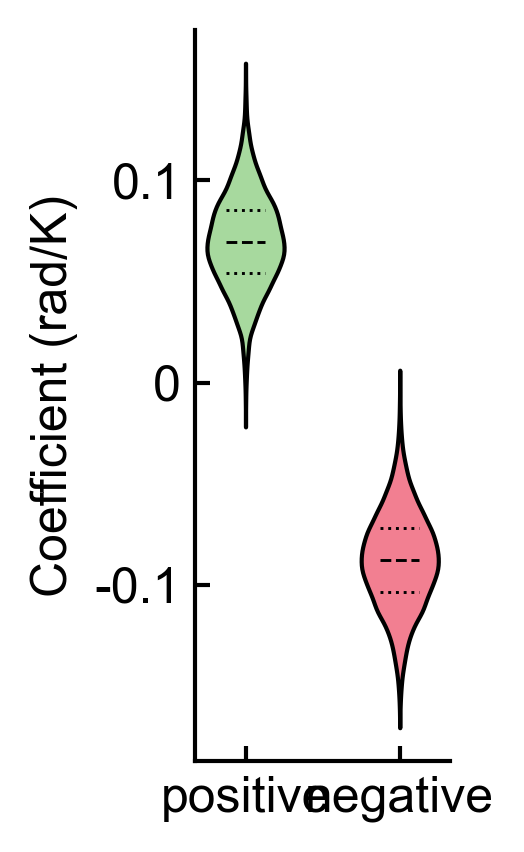

fontTools.subset - _prune_pre_subset - INFO - maxp pruned
fontTools.subset - _prune_pre_subset - INFO - LTSH dropped
fontTools.subset - _prune_pre_subset - INFO - cmap pruned
fontTools.subset - _prune_pre_subset - INFO - kern dropped
fontTools.subset - _prune_pre_subset - INFO - post pruned
fontTools.subset - _prune_pre_subset - INFO - PCLT dropped
fontTools.subset - _prune_pre_subset - INFO - GPOS pruned
fontTools.subset - _prune_pre_subset - INFO - GSUB pruned
fontTools.subset - _prune_pre_subset - INFO - JSTF dropped
fontTools.subset - _prune_pre_subset - INFO - DSIG dropped
fontTools.subset - _prune_pre_subset - INFO - name pruned
fontTools.subset - _prune_pre_subset - INFO - glyf pruned
fontTools.subset - _closure_glyphs - INFO - Added gid0 to subset
fontTools.subset - _closure_glyphs - INFO - Added first four glyphs to subset
fontTools.subset - _closure_glyphs - INFO - Closing glyph list over 'GSUB': 27 glyphs before
fontTools.subset - _log_glyphs - INFO - Glyph names: ['.notdef'

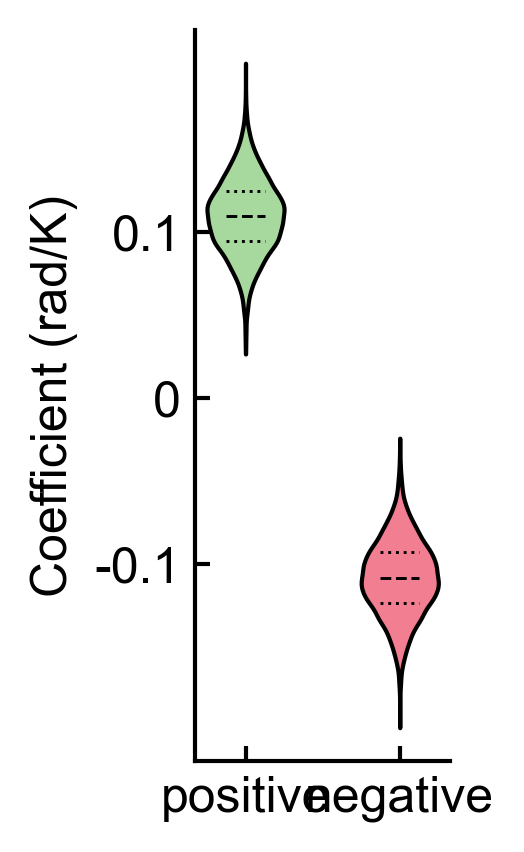

In [17]:
# coef_mean = np.mean(combine_reori_coef,axis=0)
# coef_std = np.std(combine_reori_coef,axis=0)
coef_cat_ls = [combine_reori_coef[:,i] for i in range(2,8)]
color_ls = ['#708ac1']*6
size = (3,3)
y_ticks = [-0.6,-0.3,0,0.3,0.6]
save_path = 'Fig2/Fig2_excursion_slow_amplitude_orientation_regression_bootstrap_dist.pdf'
WormTool.statistic_plot.plot_violin(coef_cat_ls,['<-6','-6~-3','-3~0','0~3','3~6','>6'],'Orientation change (rad)',color_ls=color_ls,size=size,y_ticks=y_ticks,save_path=save_path)

coef_cat_ls = [combine_reori_coef[:,i] for i in range(2)]
color_ls = ['#a7d99e','#f27f91']
size = (1.8,3)
y_ticks = [-0.1,0,0.1]
save_path = 'Fig2/Fig2_slow_amplitude_orientation_regression_bootstrap_dist.pdf'
WormTool.statistic_plot.plot_violin(coef_cat_ls,['positive','negative'],'Coefficient (rad/K)',color_ls=color_ls,size=size,y_ticks=y_ticks,save_path=save_path)

coef_cat_ls = [slow_mode_vec_coef[:,i] for i in range(2)]
color_ls = ['#a7d99e','#f27f91']
size = (1.8,3)
y_ticks = [-0.1,0,0.1]
save_path = 'Fig2/Fig2_slow_mode_only_orientation_regression_bootstrap_dist.pdf'
WormTool.statistic_plot.plot_violin(coef_cat_ls,['positive','negative'],'Coefficient (rad/K)',color_ls=color_ls,size=size,y_ticks=y_ticks,save_path=save_path)

# %%

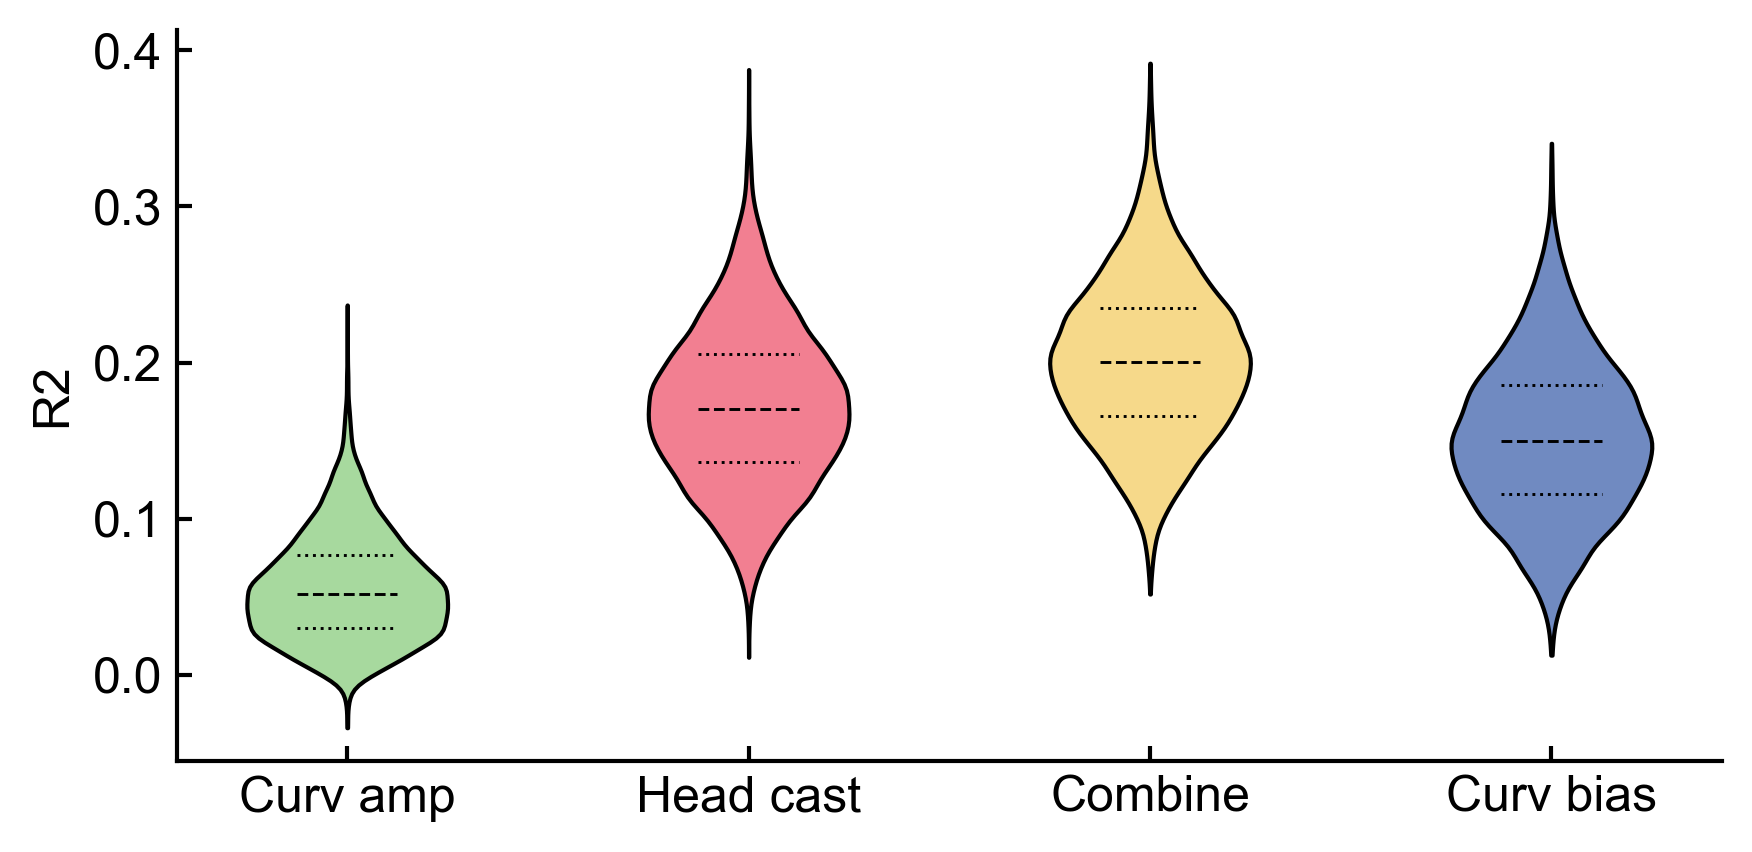

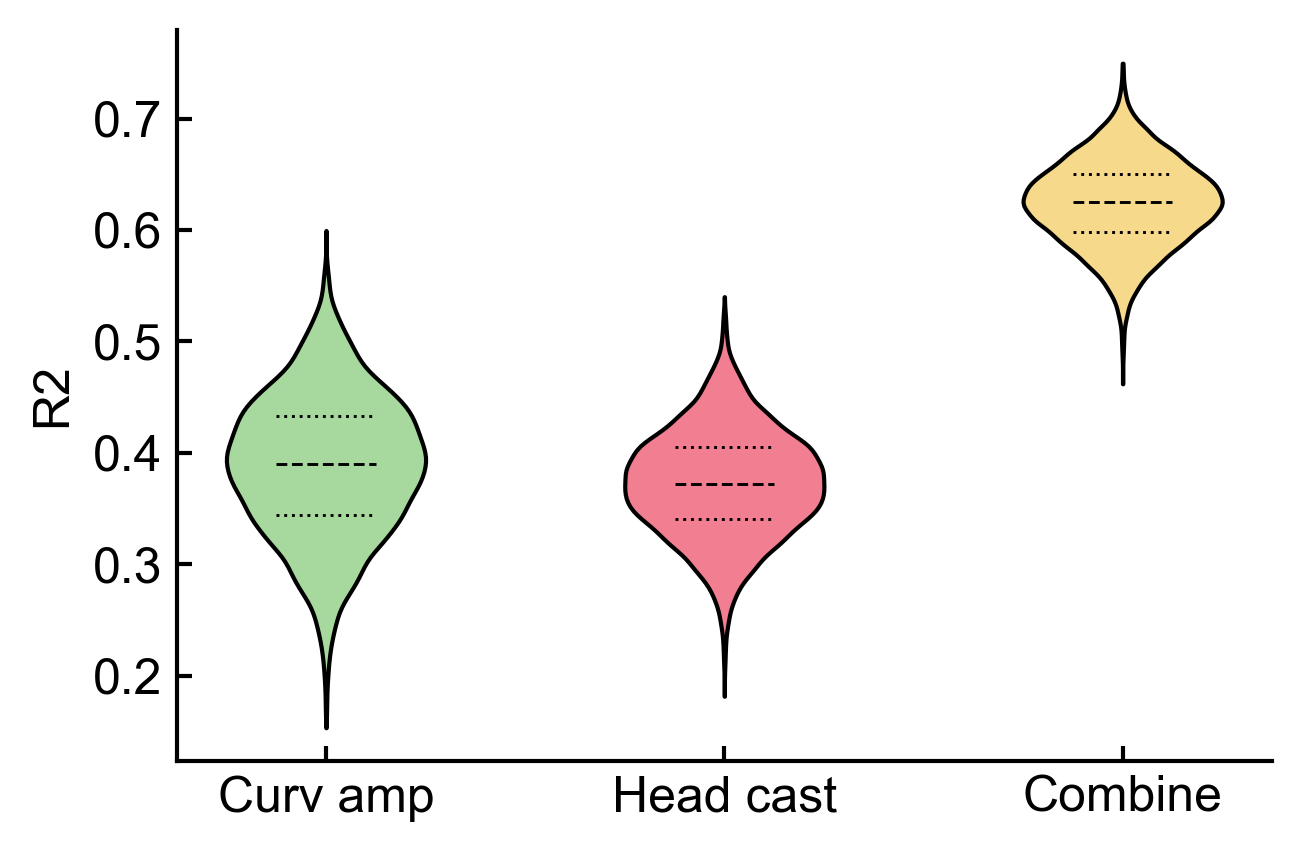

In [61]:
N_bootstrap = 10000
L = len(excursion_vec_arr)
curv_amp_reori_r2 = []
head_cast_reori_r2 = []
combine_reori_r2 = []
curv_bias_reori_r2 = []
curv_amp_curv_bias_r2 = []
head_cast_curv_bias_r2 = []
combine_curv_bias_r2 = []

def get_r2(x,y):
    # Perform linear regression using numpy's least squares method
    coef = np.linalg.lstsq(x, y, rcond=None)[0]
    # Predict y values using the regression coefficients

    y_pred = x @ coef
    # Calculate the total sum of squares
    ss_total = np.sum((y - np.mean(y))**2)
    # Calculate the residual sum of squares
    ss_residual = np.sum((y - y_pred)**2)
    # Calculate R^2
    r2 = 1 - (ss_residual / ss_total)
    return r2

for i in range(N_bootstrap):
    resample_ind = np.random.choice(L,L,replace=True)
    excursion_vec_resample = excursion_vec_arr[resample_ind]
    reorientation_resample = reorientation_arr[resample_ind]
    slow_bias_resample = slow_mode_bias_arr[resample_ind]
    slow_amp_bias_resample = slow_amp_bias_arr[resample_ind]
    slow_dur_bias_resample = slow_dur_bias_arr[resample_ind]
    curvature_bias_resample = curvature_bias_arr[resample_ind]
    curv_amp_bias_resample = curv_amp_bias_arr[resample_ind]

    curv_amp_reori_r2.append(get_r2(curv_amp_bias_resample[:,np.newaxis], reorientation_resample))
    head_cast_reori_r2.append(get_r2(excursion_vec_resample, reorientation_resample))
    combine_reori_r2.append(get_r2(np.concatenate([curv_amp_bias_resample[:,np.newaxis], excursion_vec_resample], axis=1), reorientation_resample))
    curv_bias_reori_r2.append(get_r2(curvature_bias_resample[:,np.newaxis], reorientation_resample))
    
    # target = curvature_bias_resample
    target = slow_dur_bias_resample
    curv_amp_curv_bias_r2.append(get_r2(curv_amp_bias_resample[:,np.newaxis], target))
    head_cast_curv_bias_r2.append(get_r2(excursion_vec_resample, target))
    combine_curv_bias_r2.append(get_r2(np.concatenate([curv_amp_bias_resample[:,np.newaxis], excursion_vec_resample], axis=1), target))





WormTool.statistic_plot.plot_violin([curv_amp_reori_r2,head_cast_reori_r2,combine_reori_r2,curv_bias_reori_r2 ],
                                          label_ls=['Curv amp','Head cast','Combine', 'Curv bias'],
                                          y_label='R2',
                                         )
WormTool.statistic_plot.plot_violin([curv_amp_curv_bias_r2,head_cast_curv_bias_r2,combine_curv_bias_r2 ],
                                          label_ls=['Curv amp','Head cast','Combine'],
                                          y_label='R2',
                                         )

fontTools.subset - _prune_pre_subset - INFO - maxp pruned
fontTools.subset - _prune_pre_subset - INFO - LTSH dropped
fontTools.subset - _prune_pre_subset - INFO - cmap pruned
fontTools.subset - _prune_pre_subset - INFO - kern dropped
fontTools.subset - _prune_pre_subset - INFO - post pruned
fontTools.subset - _prune_pre_subset - INFO - PCLT dropped
fontTools.subset - _prune_pre_subset - INFO - GPOS pruned
fontTools.subset - _prune_pre_subset - INFO - GSUB pruned
fontTools.subset - _prune_pre_subset - INFO - JSTF dropped
fontTools.subset - _prune_pre_subset - INFO - DSIG dropped
fontTools.subset - _prune_pre_subset - INFO - name pruned
fontTools.subset - _prune_pre_subset - INFO - glyf pruned
fontTools.subset - _closure_glyphs - INFO - Added gid0 to subset
fontTools.subset - _closure_glyphs - INFO - Added first four glyphs to subset
fontTools.subset - _closure_glyphs - INFO - Closing glyph list over 'GSUB': 21 glyphs before
fontTools.subset - _log_glyphs - INFO - Glyph names: ['.notdef'

Pearson's r: 0.08555313200201789, p-value: 0.008366781578208828


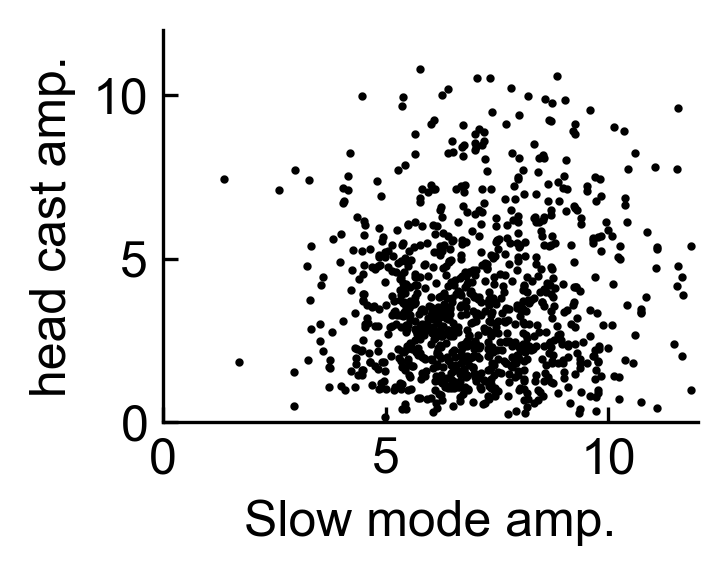

In [ ]:
# 1. Get the excursion-orientation data pairs
with open('excursion_data/excursion_trial_info_dict_MN_ablation.pkl','rb') as f:
    excursion_trial_info_dict = pickle.load(f)
excursion_info = excursion_trial_info_dict[name]
excursion_amp_ls = []
slow_mode_amp_ls = []
m = 1# number of eigenworm space cycles
shaffle = True
# Set the random seed
np.random.seed(3)
for i in range(head_curvature.shape[0]):
    if (np.isnan(full_curvature[i])).any():
        continue
    sf = np.sign(np.random.rand()-0.5) if shaffle else 1
    curvature_i = full_curvature[i]
    proj_i = curvature_i.T @ eig_worms[:,:2]
    phase = np.arctan2(proj_i[:,0], proj_i[:,1])
    orientation_i = orientation_data[i] * sf
    phase_jump = np.where(np.abs(np.diff(phase))>np.pi*0.8)[0]
    head_curv_i = head_curvature[i] * sf
    slow_curv_i = slow_mode[i] * sf
    fast_curv_i = fast_mode[i] * sf

    n_jump = len(phase_jump)
    n_record = (n_jump-2)//m
    excursion_ls = excursion_info[i]['excursion_ls']
    excursion_start_ls = [excursion['start'] for excursion in excursion_ls]
    for j in range(n_record):
        start = phase_jump[j*m]
        end = phase_jump[(j+1)*m]
        excursion_in_cycle = np.where((np.array(excursion_start_ls)>start) & (np.array(excursion_start_ls)<end))[0]
        if len(excursion_in_cycle) == 0:
            continue
        for index in excursion_in_cycle:
            # excursion_amp = (excursions[index]['sign'].astype(np.float32))*abs(head_curvature_sm[excursions[index]['start']]-head_curvature_sm[excursions[index]['end']])
            # excursion_amp = (np.sign(head_curvature_sm[excursions[index]['pre_peak']]))*abs(head_curvature_sm[excursions[index]['start']]-head_curvature_sm[excursions[index]['end']])
            excursion_amp = abs(head_curv_i[excursion_ls[index]['start']]-head_curv_i[excursion_ls[index]['end']])
            excursion_sign = np.sign((head_curv_i[excursion_ls[index]['start']] + head_curv_i[excursion_ls[index]['end']])/2)
            
            excursion_amp_ls.append(excursion_amp)
            if excursion_sign > 0:
                slow_mode_amp_ls.append(abs(np.max(slow_curv_i[start:end])))
            else:
                slow_mode_amp_ls.append(abs(np.min(slow_curv_i[start:end])))


from scipy.stats import pearsonr

excursion_amp_ls = np.array(excursion_amp_ls)
slow_mode_amp_ls = np.array(slow_mode_amp_ls)

# Calculate Pearson's r
r, p_value = pearsonr(slow_mode_amp_ls, excursion_amp_ls)
print(f"Pearson's r: {r}, p-value: {p_value}")

#%%
fig,ax = plt.subplots(1,1,figsize=(2.3,1.7),dpi=300)
ax.plot(slow_mode_amp_ls,excursion_amp_ls,'k.',markersize=2)
ax.set_xlabel('Slow mode amp.',fontsize=12)
ax.set_ylabel('head cast amp.',fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0,12])
ax.set_ylim([0,12])

plt.savefig('Fig2/Fig2_excursion_amp_slow_mode_amp.pdf')



#%%